# Lab-08: Knowledge Graph

A Knowledge Graph is a powerful tool for organizing and integrating information into an interconnected network of entities (like people, places, concepts) and their relationships.


This lab uses materials from:
1. https://iccl.inf.tu-dresden.de/w/images/f/f2/EDBT-Summer-School-2019-Knowledge-Graphs-1-wikidata-sparql.pdf
2. https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk
3. https://itnext.io/extracting-data-from-wikidata-using-sparql-and-python-59e0037996f
4. https://www.learndatasci.com/glossary/cosine-similarity/


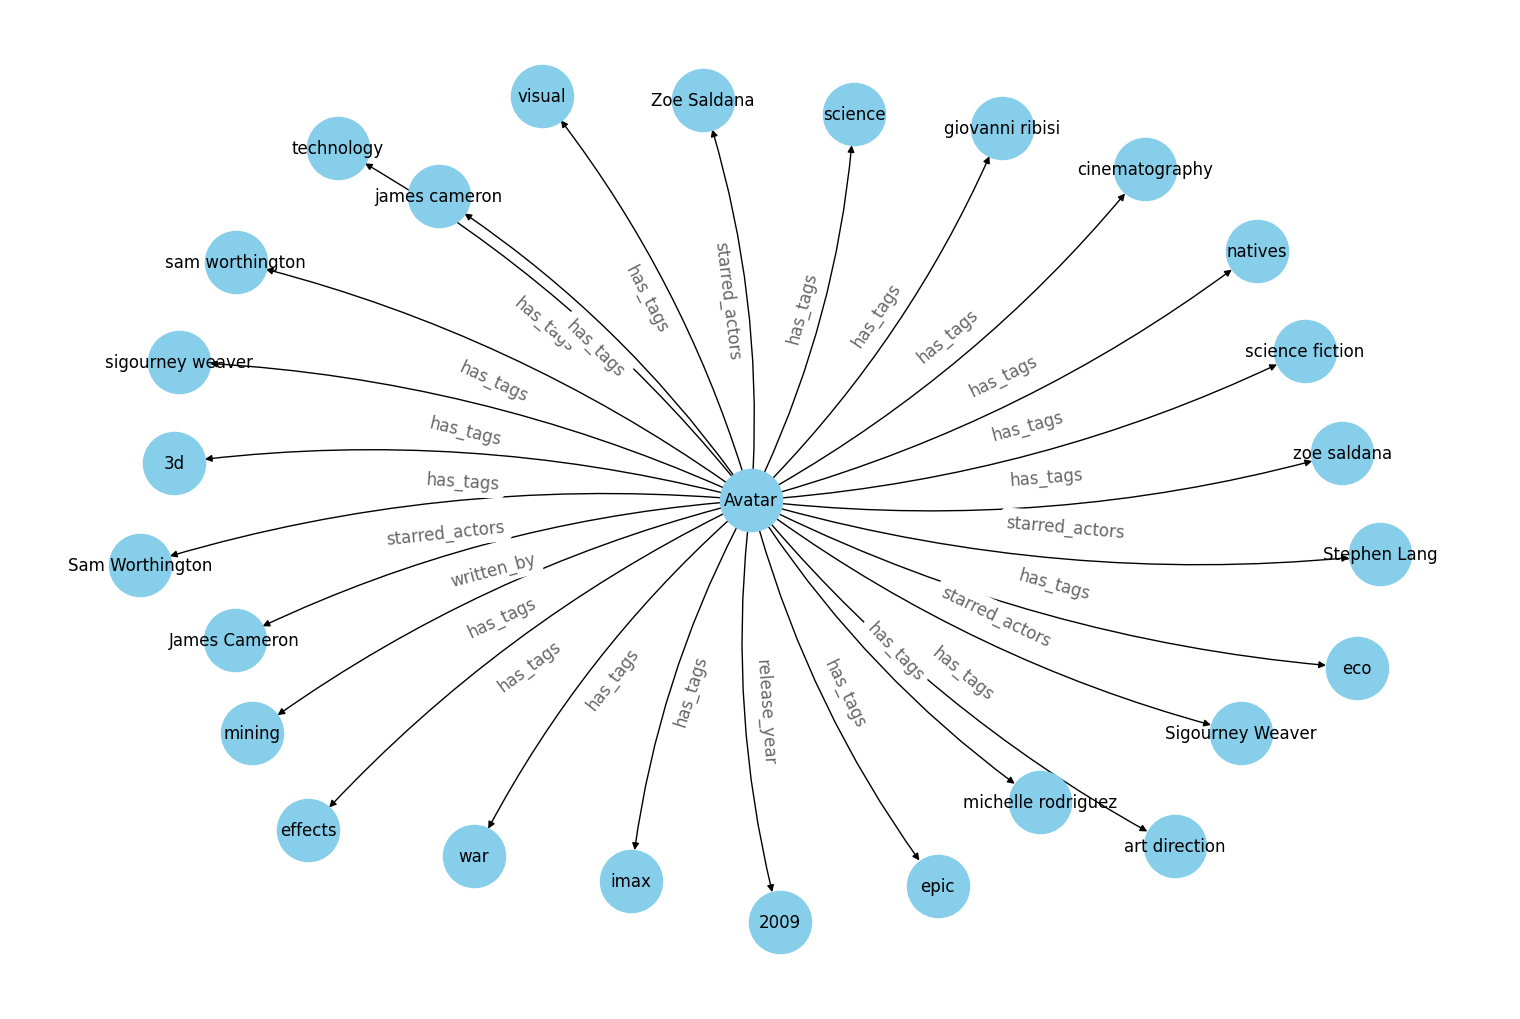

## Goals

This lab aims to answer the following questions:

1. **What is a Knowledge Graph?**
   - Understanding the basic concept and structure of KGs.

2. **How are Knowledge Graphs Constructed?**
   - Learning about the data sources for KGs.
   - Understanding the process of integrating and linking data.
   - Exploring the role of entities, attributes, and relationships.

3. **How to Visualize and Analyze Data from a Knowledge Graph?**
   - Techniques for visualizing KGs.
   - Basic analysis to extract insights from KGs.

4. **How to Query and Interact with a Knowledge Graph?**
   - Introduction to SPARQL, a query languages used with KGs.
   - Hands-on practice with querying a KG (using a public KG like Wikidata).

### Why Industries are Interested in Knowledge Graphs:

- **Enhanced Question Answering (QA) Systems**: Knowledge Graphs enable more accurate and context-aware answers in QA systems, improving user experience in search engines, virtual assistants, and customer support tools.
- **Improved Entity Resolution**: By mapping complex relationships and various attributes of entities, Knowledge Graphs can be used in accurately identifying, linking, and disambiguating entities. This is crucial in domains like e-commerce, content management, and data integration.

These graphs not only store facts but also the connections and contexts that give those facts meaning, leading to more insightful data analysis and decision-making.


In [73]:
# Some imports

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns
import plotly as py
#import pygraphviz

## for text
#import wikipedia
import nltk  #3.8.1
import re

## for nlp
import spacy  #3.5.0
from spacy import displacy
#import textacy  #0.12.0

## for graph
import networkx as nx

## for timeline
#import dateparser #1.1.7

## for distances
from scipy.spatial.distance import cosine

%matplotlib inline

## Knowledge Graph Basics

### What is Knowledge Graph? <a id="KG11"></a> <br>

A knowledge graph is a way of storing data that resulted from an information extraction task. Many basic implementations of knowledge graphs make use of a concept we call triple, that is a set of three items(a subject, a predicate and an object) that we can use to store information about something.

**We can define a graph as a set of nodes and edges.**

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/graph_link.png)

Node A and Node B here are two different entities. These nodes are connected by an edge that represents the relationship between the two nodes. Now, this is the smallest knowledge graph we can build – it is also known as a **triple**. Knowledge Graph’s come in a variety of shapes and sizes.

## Wikidata

Wikidata [CACM 2014]:

1. Wikipedia’s knowledge graph

2. Free, community-built

3. Large graph
(August 2019: >733M statements on >58M entities)

4. Large, active community (>12,000 active editors in July 2019)


https://www.wikidata.org/wiki/Q80

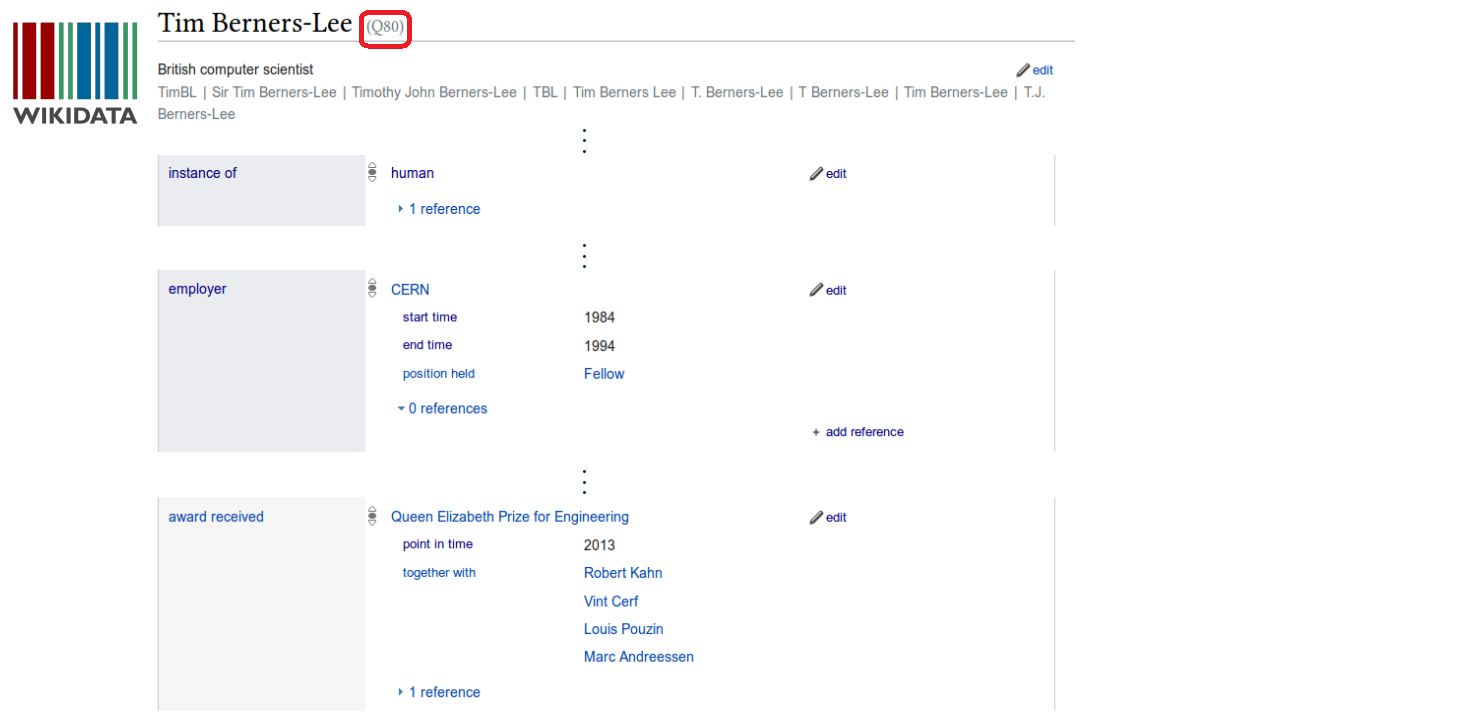

### Wikidata’s IDs

**QIDs**: Entities

**PIDs**: Relations

Why does Wikidata use abstract (numeric) QIDs and PIDs rather than something more readable?

International
- Identifiers work for any language and
cultural backgrounds

Stable
- Labels can change without IDs changing
- Multiple entities can have the same label
- IDs of deleted entities are never used
again

Convenient
- Numeric IDs are quite short
- Uniform format is practical


How to find the ID of an item?
Main methods:

(1) Use the auto-completing
search bar on wikidata.org

(2) Go to the item’s Wikipedia
page and select “Wikdata
item” from the sidebar


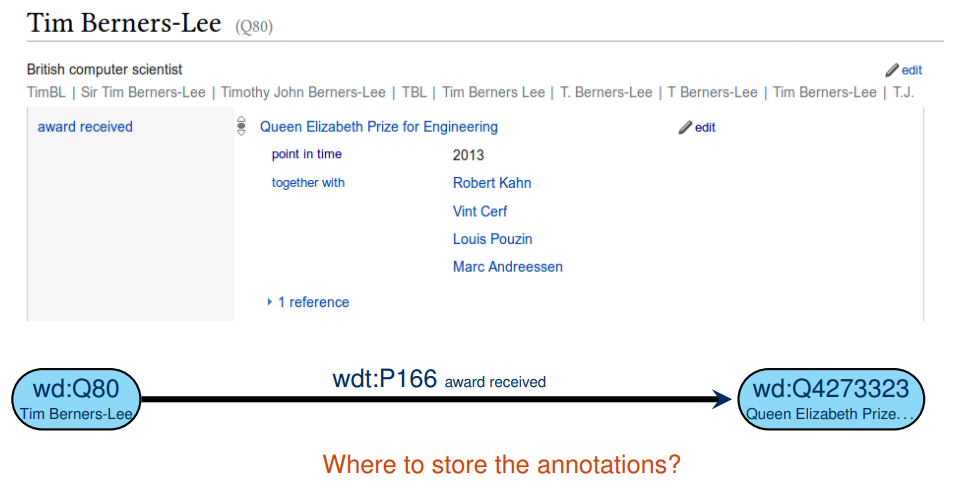

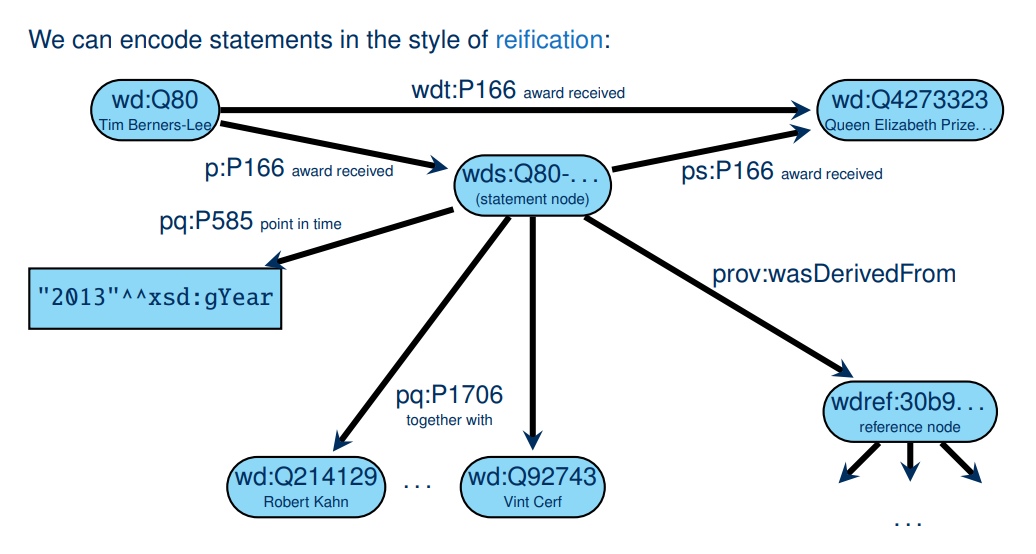

### Query Wikidata - SPARQL

**SPARQL** is a powerful query language used for live queries on Wikidata.

https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial



In [2]:
!pip -q install qwikidata
!pip -q install sparqlwrapper

from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api
import sys
import seaborn as sns
import folium # mapping
from folium.plugins import HeatMap
import missingno as msno
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from typing import List, Dict

import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.0 MB/s eta 0:00:00
Setup Complete


In [3]:
# modified from https://itnext.io/extracting-data-from-wikidata-using-sparql-and-python-59e0037996f
import json
import ast

class WikiDataQueryResults:
    """
    A class that can be used to query data from Wikidata using SPARQL and return the results as a Pandas DataFrame or a list
    of values for a specific key.
    """
    def __init__(self, query: str):
        """
        Initializes the WikiDataQueryResults object with a SPARQL query string.
        :param query: A SPARQL query string.
        """
        self.user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
        self.endpoint_url = "https://query.wikidata.org/sparql"
        self.sparql = SPARQLWrapper(self.endpoint_url, agent=self.user_agent)
        self.sparql.setQuery(query)
        self.sparql.setReturnFormat(JSON)

    def __transform2dicts(self, results: List[Dict]) -> List[Dict]:
        """
        Helper function to transform SPARQL query results into a list of dictionaries.
        :param results: A list of query results returned by SPARQLWrapper.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        new_results = []
        for result in results:
            print(result)
            break
            new_result = {}
            for key in result:
                new_result[key] = result[key]['value']
            new_results.append(new_result)
        return new_results

    # Function to remove invalid control characters
    def __remove_invalid_chars(text):
        return ''.join(char for char in text if ord(char) > 31 or char == '\n' or char == '\t')

    def _load(self) -> List[Dict]:
        """
        Helper function that loads the data from Wikidata using the SPARQLWrapper library, and transforms the results into
        a list of dictionaries.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        results = self.sparql.queryAndConvert()['results']['bindings']
        # Preprocess the JSON response to remove control characters
        results = json.dumps(results).encode('utf-8').decode('unicode_escape')

        return results

    def load_as_dataframe(self) -> pd.DataFrame:
        """
        Executes the SPARQL query and returns the results as a Pandas DataFrame.
        :return: A Pandas DataFrame representing the query results.
        """
        results = self._load()
        df = pd.read_json(results)
        df = df.applymap(lambda x: x['value'])
        return df

As introduced at the beginning of this section.

To locate the QIDs (Wikidata item identifiers) and PIDs (property identifiers), a simple approach is to do a Google search with terms like "Interstellar (film) Wikidata". Alternatively, you can directly search on Wikidata's main website for more precise results.

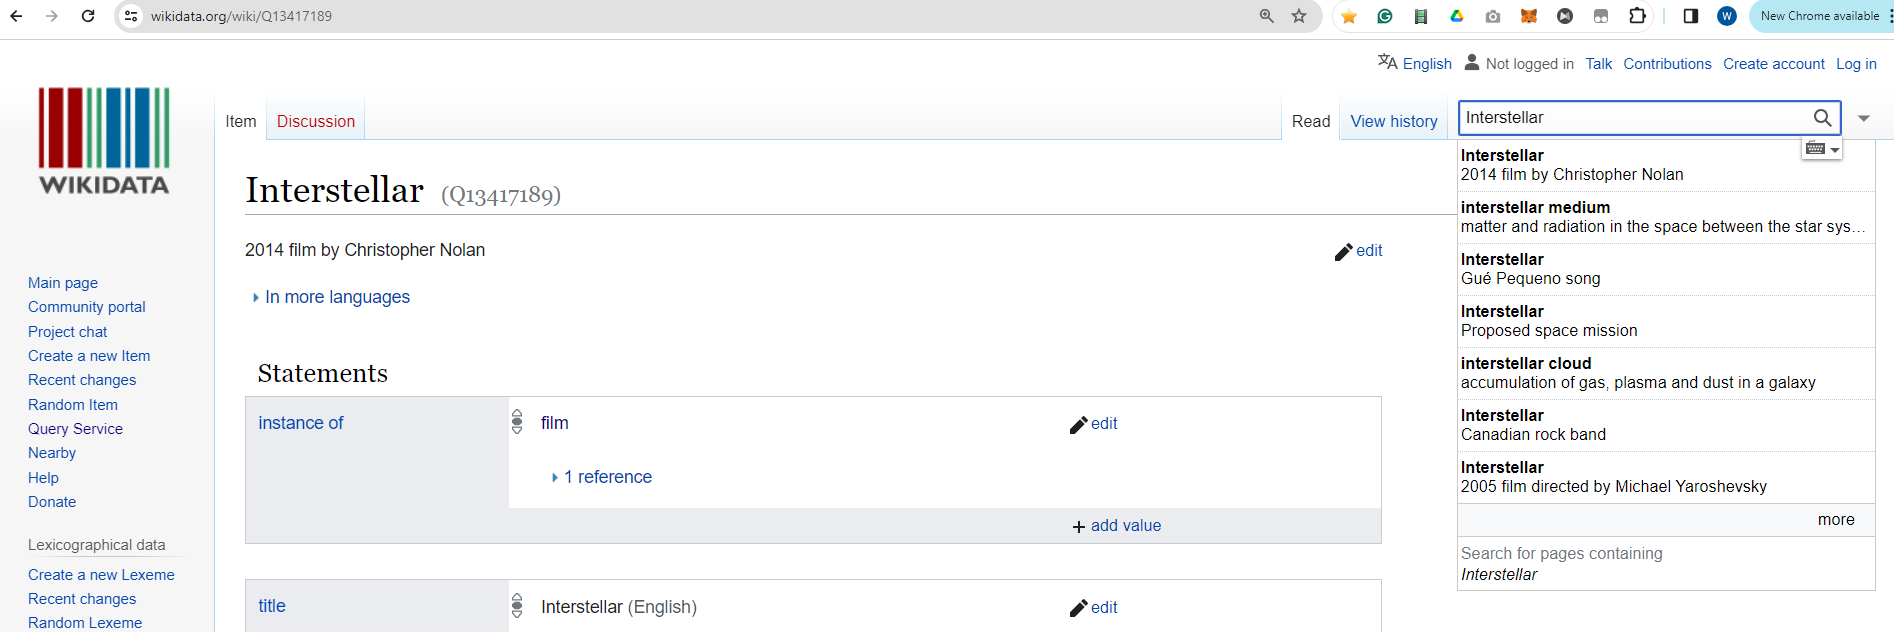

You can also get into any Wikidata page directly from the Wikipedia!



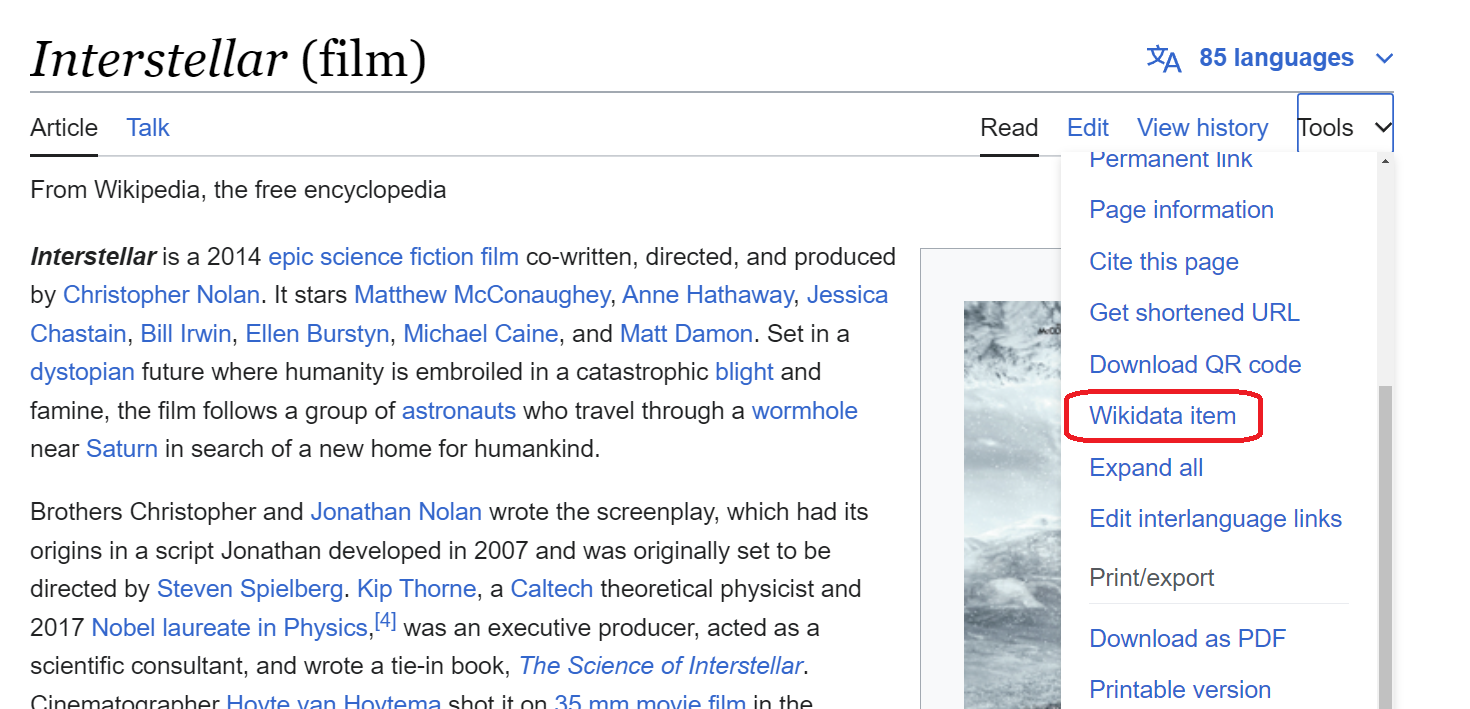

#### Movie query

In [4]:
movieQuery = """
# distinct mean we want no duplicate in the set of entities (or variables) you are selecting in your query
# so here we will have distinct ( ?actor, ?actorLabel ) tuples
SELECT distinct ?actor ?actorLabel
WHERE {
  # wd:Q13417189: [Entity] Interstellar (film) - https://www.wikidata.org/wiki/Q13417189
  # wdt:P161: [Relation] cast member https://www.wikidata.org/wiki/Property:P161
  # So the following line in English: give me all actors that are cast in the movie Interstellar
  wd:Q13417189 wdt:P161 ?actor.

  # This line will map the actor (PIDs) to their labels actorLabel (actual names), in your choice of language
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
# We limit the number of returned results to 100
limit 100
"""

In [5]:
# This query will give us what you specified in after the select: ?actor and ?actorLabel
data_extracter = WikiDataQueryResults(movieQuery)
Interstellar_df = data_extracter.load_as_dataframe()
Interstellar_df

,actor,actorLabel
0,http://www.wikidata.org/entity/Q117415,Josh Stewart
1,http://www.wikidata.org/entity/Q235725,Brooke Smith
2,http://www.wikidata.org/entity/Q277978,Topher Grace
3,http://www.wikidata.org/entity/Q603317,Bill Irwin
4,http://www.wikidata.org/entity/Q311271,John Lithgow
5,http://www.wikidata.org/entity/Q2636244,Jeff Hephner
6,http://www.wikidata.org/entity/Q461623,Leah Cairns
7,http://www.wikidata.org/entity/Q175535,Matt Damon
8,http://www.wikidata.org/entity/Q123351,Michael Caine
9,http://www.wikidata.org/entity/Q94913,Mackenzie Foy


Let's use NetworkX to visualize this as a knowledge graph

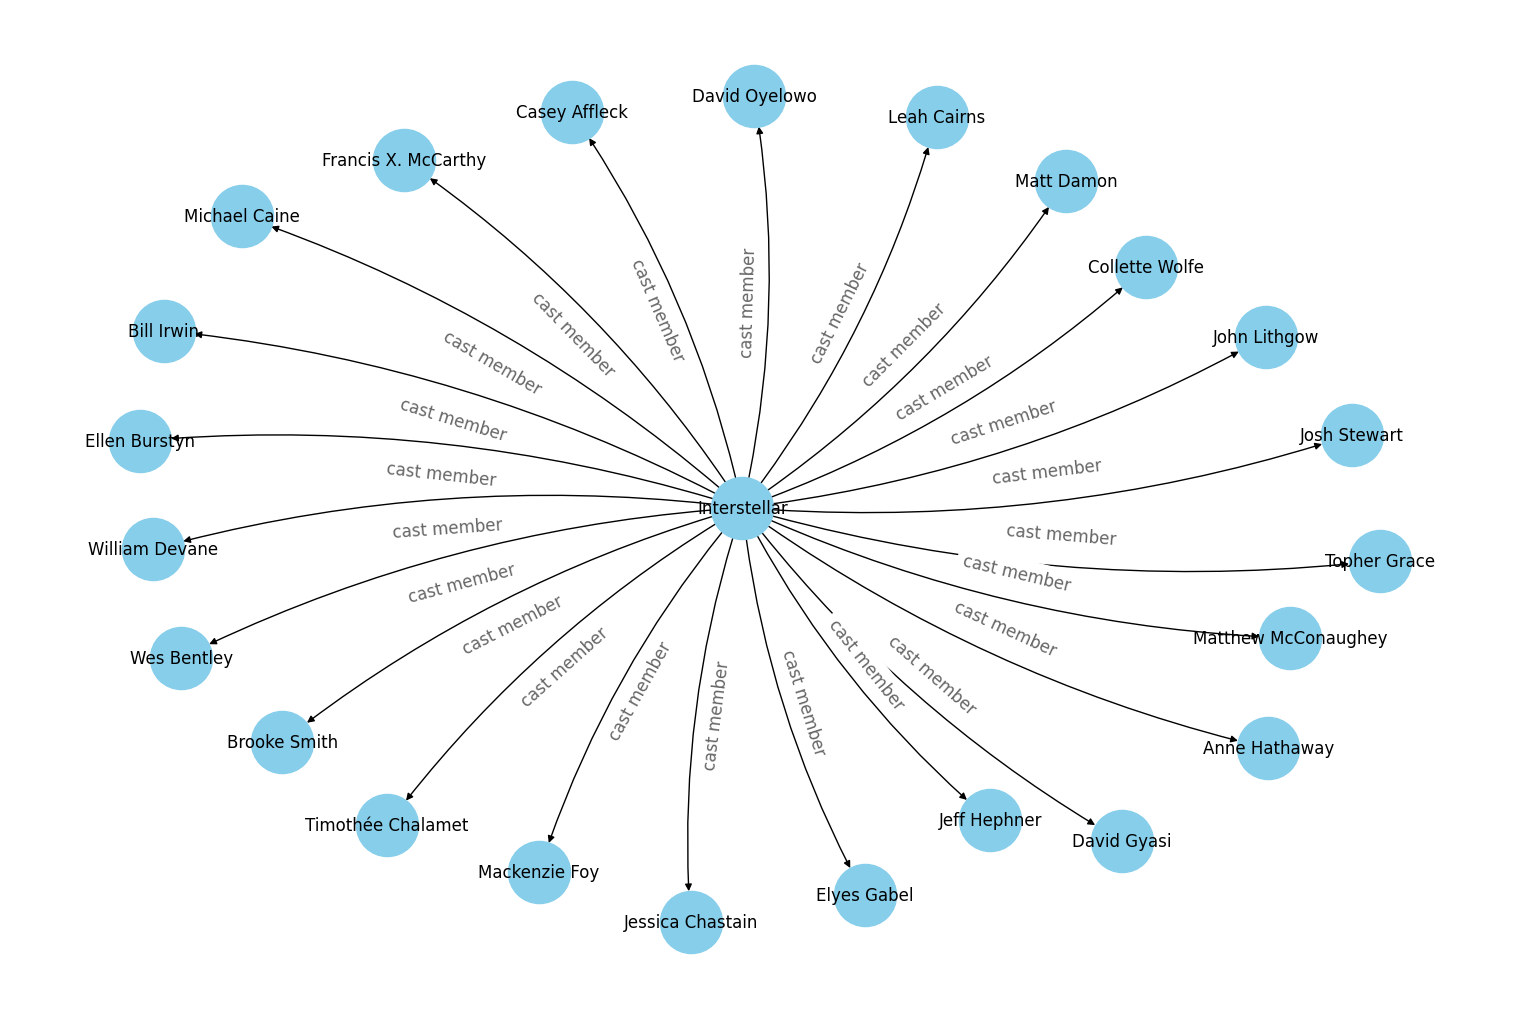

In [6]:
## create full graph

def df_to_KG(df, source_col, target_col, relation_col):
  """
  Source - relation -> target
  """
  G = nx.from_pandas_edgelist(df, source=source_col, target=target_col,
                              edge_attr=relation_col,
                              create_using=nx.DiGraph())

  ## plot
  plt.figure(figsize=(15,10))

  pos = nx.spring_layout(G, k=1)
  node_color = "skyblue"
  edge_color = "black"

  nx.draw(G, pos=pos, with_labels=True, node_color=node_color,
          edge_color=edge_color, cmap=plt.cm.Dark2,
          node_size=2000, connectionstyle='arc3,rad=0.1')

  nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5,
                          edge_labels=nx.get_edge_attributes(G,'relation'),
                          font_size=12, font_color='black', alpha=0.6)
  plt.show()

# We add the source node and relation back
Interstellar_df["movie"] = "Interstellar"
Interstellar_df["relation"] = "cast member"

# Plot the knowledge graph
df_to_KG(Interstellar_df, "movie", "actorLabel", "relation")

#### Actor query

We can then focus on the actor "Matthew McConaughey" and examine, for example, all his movies sort by the boxoffice.

We can directly find his QID in the row:

11	http://www.wikidata.org/entity/Q188955	Matthew McConaughey

In [7]:
actorQuery = """
SELECT distinct ?movie ?movieLabel ?genreLabel ?boxOffice
WHERE {
  # Movie - cast member -> Matthew McConaughey
  ?movie wdt:P161 wd:Q188955.
  # Movie - box office -> ?boxOffice (a number)
  ?movie wdt:P2142 ?boxOffice.
  # Movie - genre -> ?genre
  ?movie wdt:P136 ?genre.

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
# Order by descending box office
ORDER BY DESC(?boxOffice)
# We can add limit 10 here to show only the Top 10, but this time we will do it after in the pandas
#limit 10
"""

**Important clarification**:

```
  # Movie - cast member -> Matthew McConaughey
  ?movie wdt:P161 wd:Q188955.
  # Movie - box office -> ?boxOffice (a number)
  ?movie wdt:P2142 ?boxOffice.
  # Movie - genre -> ?genre
  ?movie wdt:P136 ?genre.
```

This will only return movies have cast member, box office and genre relation.

(**Optional content, not going to test**) If you want to include movies with or without those relations, use OPTIONAL as below.

```
  # Movie - cast member -> Matthew McConaughey
  OPTIONAL { ?movie wdt:P161 wd:Q188955.}
  # Movie - box office -> ?boxOffice (a number)
  OPTIONAL { ?movie wdt:P2142 ?boxOffice.}
  # Movie - genre -> ?genre
  OPTIONAL { ?movie wdt:P136 ?genre.}
```

In [79]:
Matthew_df = WikiDataQueryResults(actorQuery).load_as_dataframe()
Matthew_df

,movie,movieLabel,genreLabel,boxOffice
0,http://www.wikidata.org/entity/Q42759035,Joker,drama film,1074458282
1,http://www.wikidata.org/entity/Q42759035,Joker,crime film,1074458282
2,http://www.wikidata.org/entity/Q42759035,Joker,thriller film,1074458282
3,http://www.wikidata.org/entity/Q42759035,Joker,psychological thriller film,1074458282
4,http://www.wikidata.org/entity/Q128518,Gladiator,drama film,460583960
5,http://www.wikidata.org/entity/Q128518,Gladiator,action film,460583960
6,http://www.wikidata.org/entity/Q128518,Gladiator,adventure film,460583960
7,http://www.wikidata.org/entity/Q128518,Gladiator,epic film,460583960
8,http://www.wikidata.org/entity/Q128518,Gladiator,sword-and-sandal film,460583960
9,http://www.wikidata.org/entity/Q128518,Gladiator,melodrama,460583960


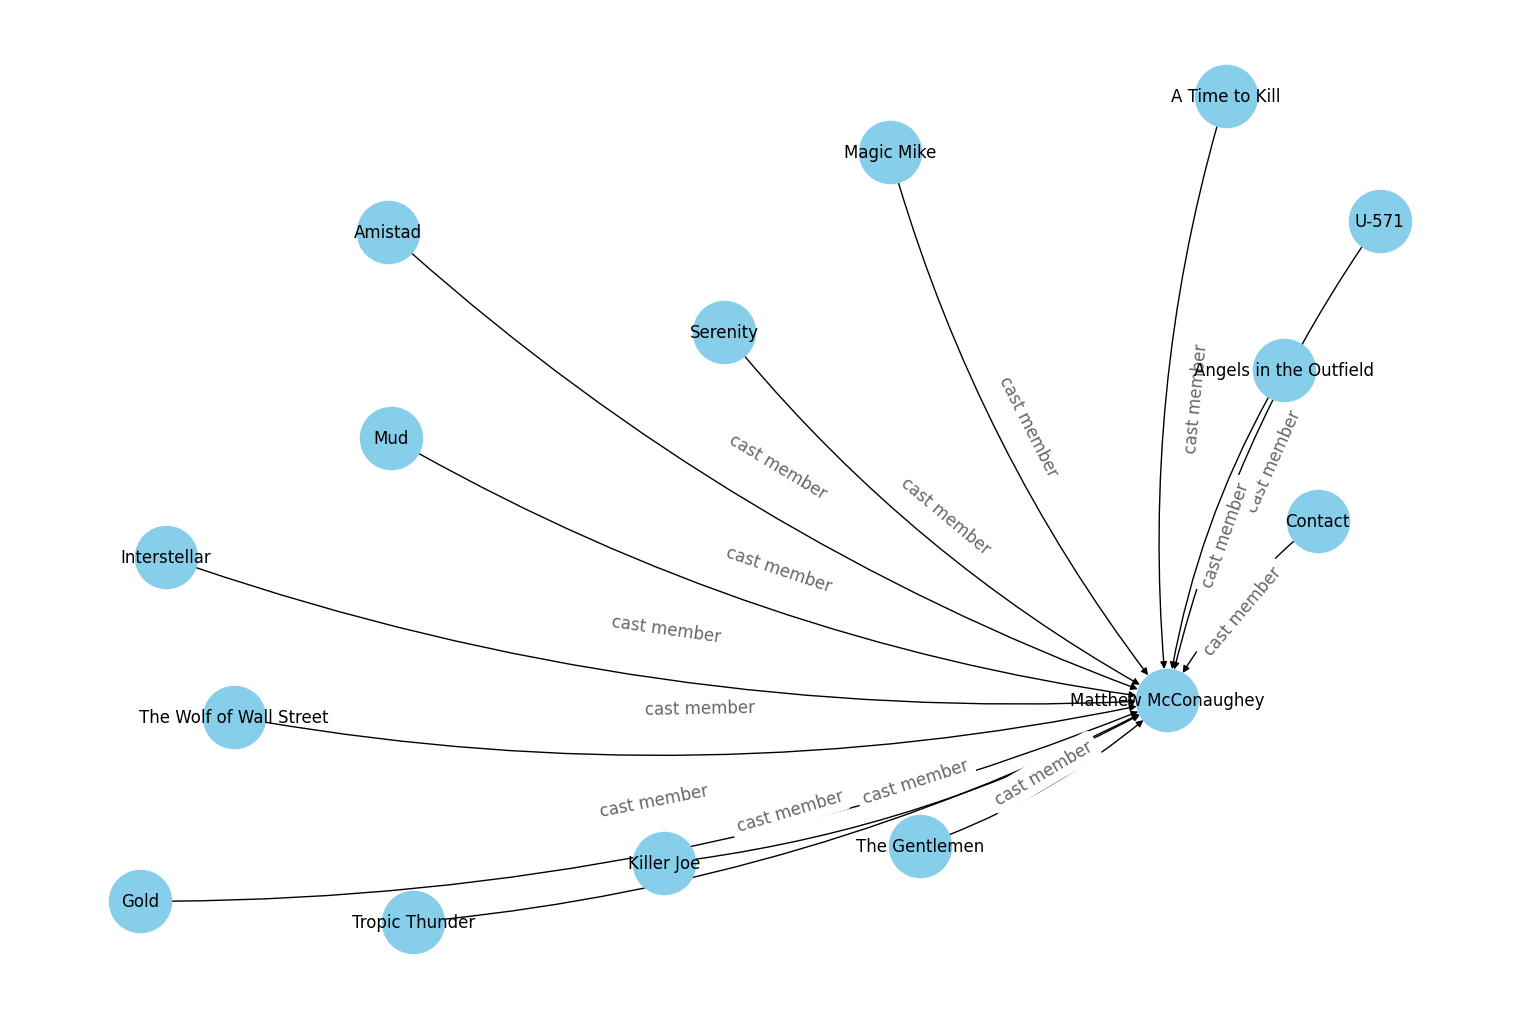

In [9]:
# Matthew and movies
Matthew_movie_df = Matthew_df.drop_duplicates(subset=["movieLabel"])
Matthew_movie_df["actor"]="Matthew McConaughey"
Matthew_movie_df["relation"]="cast member"

df_to_KG(Matthew_movie_df, "movieLabel", "actor", "relation")

##### Actor and genres

<Axes: ylabel='genreLabel'>

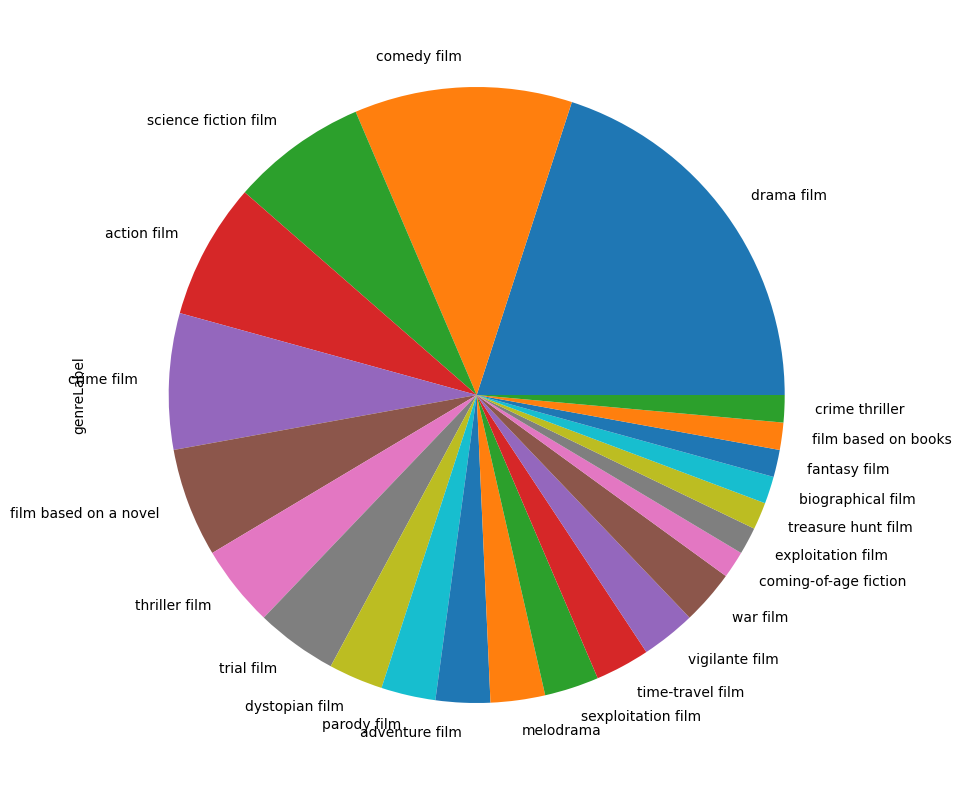

In [10]:
# Matthew and genres

# Counting each genre
genre_counts = Matthew_df['genreLabel'].value_counts()

# Normalizing the counts
Matthew_normalized_genre_vector = genre_counts / genre_counts.sum()

Matthew_normalized_genre_vector.plot(kind='pie' , figsize=(10,10))

# drama guy, but really diversed

<Axes: ylabel='genreLabel'>

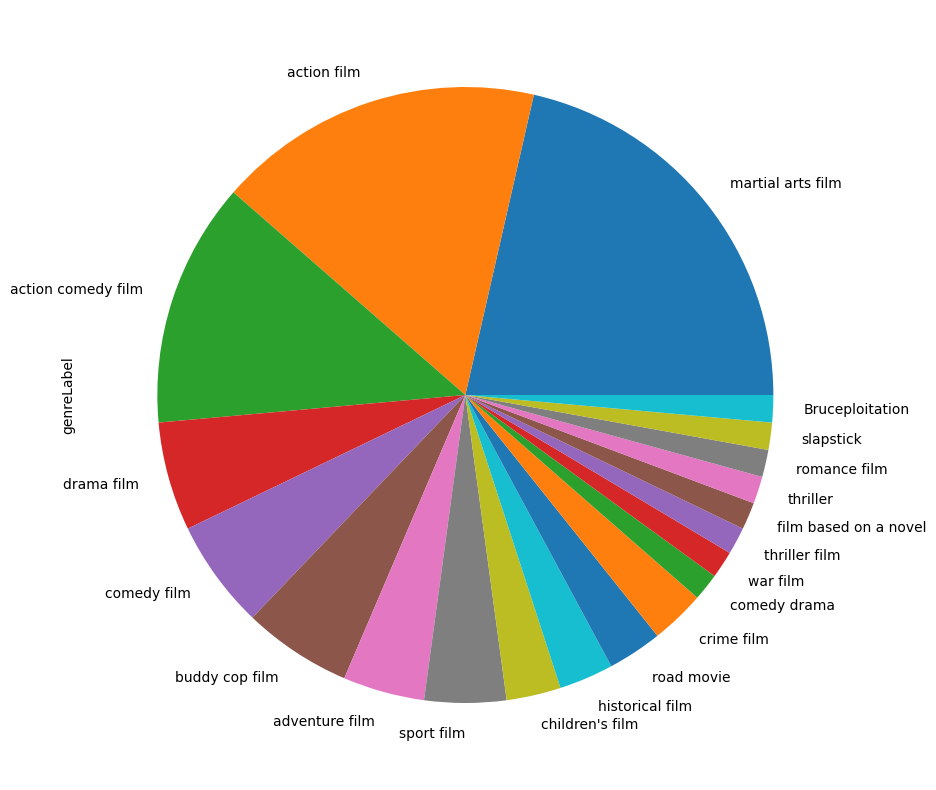

In [11]:
# We would expect a very different pie graph for, say, JackieChan

actorQuery = """
SELECT distinct ?movie ?movieLabel ?genreLabel ?boxOffice
WHERE {
  # Movie - cast member -> Jackie Chan
  ?movie wdt:P161 wd:Q36970.
  # Movie - box office -> ?boxOffice (a number)
  ?movie wdt:P2142 ?boxOffice.
  # Movie - genre -> ?genre
  ?movie wdt:P136 ?genre.

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
# Order by descending box office
ORDER BY DESC(?boxOffice)
"""

Jackie_df = WikiDataQueryResults(actorQuery).load_as_dataframe()
genre_counts = Jackie_df['genreLabel'].value_counts()
Jackie_normalized_genre_vector = genre_counts / genre_counts.sum()
Jackie_normalized_genre_vector.plot(kind='pie' , figsize=(10,10))

##### Cosine Similarity

You were introduced to vectors in your first-year algebra class.

These can be applied to create pie charts that represent actors, which are essentially vectors of normalized proportions of the different genres they have participated in.

In [12]:
print("Matthew vector", Matthew_normalized_genre_vector)

Matthew vector drama film               0.200000
comedy film              0.114286
science fiction film     0.071429
action film              0.071429
crime film               0.071429
film based on a novel    0.057143
thriller film            0.042857
trial film               0.042857
dystopian film           0.028571
parody film              0.028571
adventure film           0.028571
melodrama                0.028571
sexploitation film       0.028571
time-travel film         0.028571
vigilante film           0.028571
war film                 0.028571
coming-of-age fiction    0.014286
exploitation film        0.014286
treasure hunt film       0.014286
biographical film        0.014286
fantasy film             0.014286
film based on books      0.014286
crime thriller           0.014286
Name: genreLabel, dtype: float64


In [13]:
print("Jackie vector", Jackie_normalized_genre_vector)

Jackie vector martial arts film        0.214286
action film              0.171429
action comedy film       0.128571
drama film               0.057143
comedy film              0.057143
buddy cop film           0.057143
adventure film           0.042857
sport film               0.042857
children's film          0.028571
historical film          0.028571
road movie               0.028571
crime film               0.028571
comedy drama             0.014286
war film                 0.014286
thriller film            0.014286
film based on a novel    0.014286
thriller                 0.014286
romance film             0.014286
slapstick                0.014286
Bruceploitation          0.014286
Name: genreLabel, dtype: float64


We can calculate the dot product of these vectors, then divided by the product of their lengths, to represent how similar they are.

$$\text{Cosine Similarity} = \frac{\sum_{i=1}^{n} A_i \times B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \times \sqrt{\sum_{i=1}^{n} B_i^2}}$$

Certainly! The equation for cosine similarity in LaTeX notation is:

In this equation:
- $ A_i $ and $ B_i $ are the components of vectors $A$ and $B$, respectively.
- $ \sum_{i=1}^{n} A_i \times B_i $ is the dot product of vectors $A$ and $B$.
- $ \sqrt{\sum_{i=1}^{n} A_i^2} $ and $ \sqrt{\sum_{i=1}^{n} B_i^2} $ are the magnitudes (or norms, lengths) of vectors $A$ and $B$, respectively.



This concept is referred to as **Cosine similarity** (https://en.wikipedia.org/wiki/Cosine_similarity). Intuitively, it's the is the cosine of the angle between the vectors.

We won't delve deeply into this concept. All you need to understand for now, is that Cosine similarity values range from -1 to 1, where higher values signify more similarity.

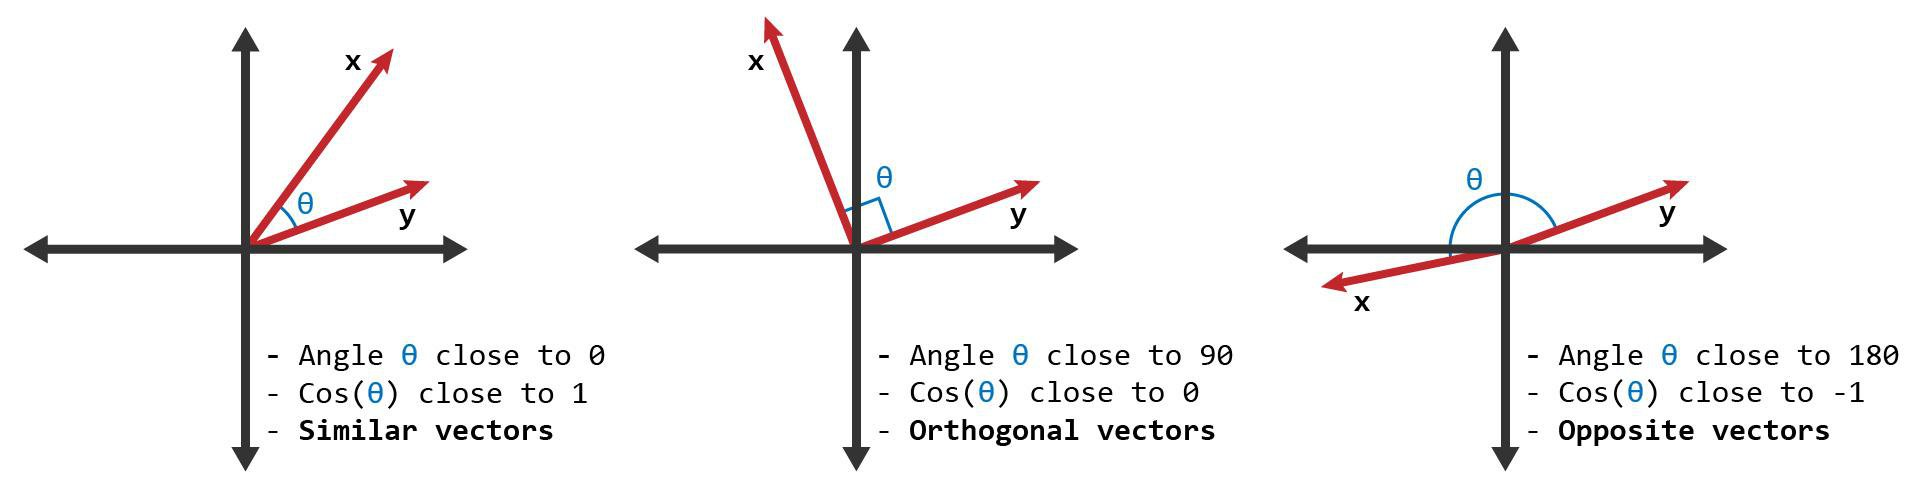

In [74]:
def actor_cosine_similarity(vector1, vector2):
  # Combine the indices (genres) and remove duplicates
  all_genres = vector1.index.union(vector2.index)

  # Reindex both series to have the same genres
  actor1_series = vector1.reindex(all_genres, fill_value=0)
  actor2_series = vector2.reindex(all_genres, fill_value=0)

  # Calculate the cosine similarity
  # scipy.spatial.distance.cosine is cosine distance
  # cosine similarity is just (1 - cosine distance)
  pair_cosine_similarity = 1 - cosine(actor1_series, actor2_series)

  print(f'Cosine similarity: {pair_cosine_similarity:.2f}')

In [75]:
actor_cosine_similarity(Matthew_normalized_genre_vector,Jackie_normalized_genre_vector)
# So they are not very similar actors in terms of genres, you kind of sense this with their pie plots

# Quick question, can we have negative similarities in this setting?
# The answer is no, since we will not have negative counts ( of movie with genres )


Cosine similarity: 0.37


<Axes: ylabel='genreLabel'>

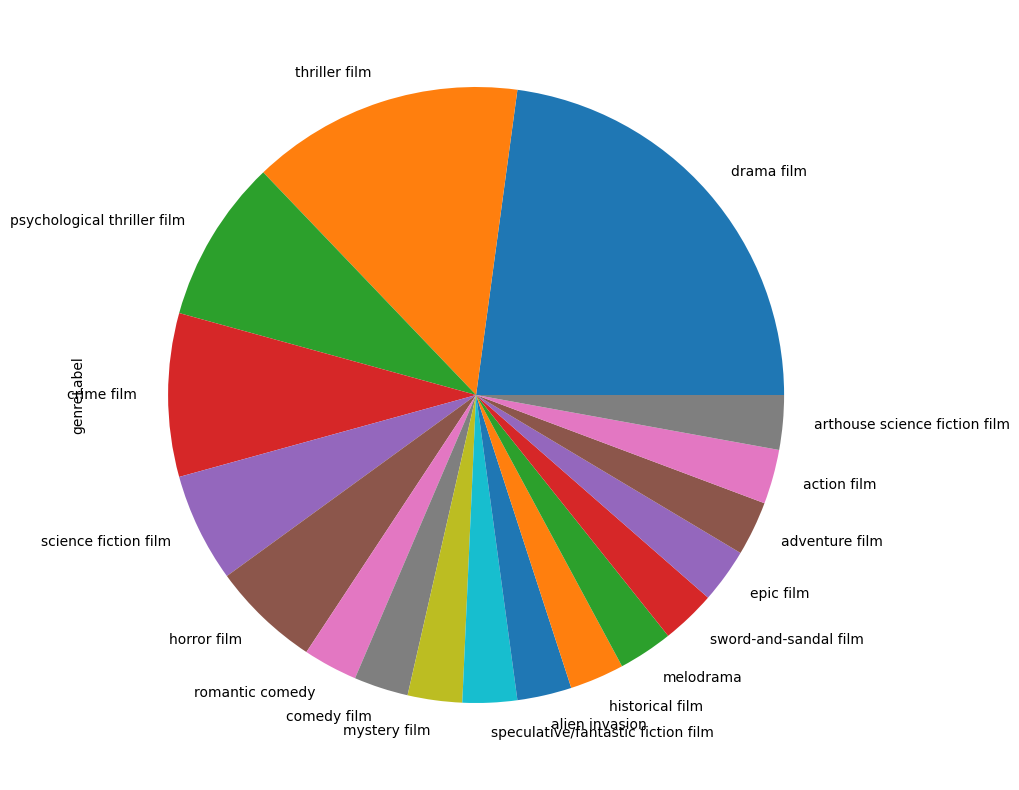

In [48]:
# Now let's check someone that would be consider "closer" in this similarity, e.g. Joaquin Phoenix

actorQuery = """
SELECT distinct ?movie ?movieLabel ?genreLabel ?boxOffice
WHERE {
  # Movie - cast member -> Joaquin Phoenix
  ?movie wdt:P161 wd:Q185140.
  # Movie - box office -> ?boxOffice (a number)
  ?movie wdt:P2142 ?boxOffice.
  # Movie - genre -> ?genre
  ?movie wdt:P136 ?genre.

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
# Order by descending box office
ORDER BY DESC(?boxOffice)
"""

Joaquin_df = WikiDataQueryResults(actorQuery).load_as_dataframe()
genre_counts = Joaquin_df['genreLabel'].value_counts()
Joaquin_normalized_genre_vector = genre_counts / genre_counts.sum()
Joaquin_normalized_genre_vector.plot(kind='pie' , figsize=(10,10))

In [52]:
actor_cosine_similarity(Matthew_normalized_genre_vector,Joaquin_normalized_genre_vector)

# Joaquin Phoenix and Matthew McConaughey are more alike than Jackie Chan is to Matthew, if you go by the actor-genre cosine similarity.

Cosine similarity: 0.74


Wikidata opens up a world of possibilities for interesting queries.

It also offers a versatile QueryBuilder in their WebUI for easy query creation through a user-friendly interface. While it's not covered in this session, you're encouraged to experiment with crafting your own queries, either manually or using this tool.

Explore it here: [Wikidata QueryBuilder](https://query.wikidata.org/querybuilder/).

In [15]:
# Or, you can make you own functions from the query and API
# For example
def find_movie_info(movie_QIDs):
  """
  movie_QIDs is a list of QIDs [ "Qxxx", "Qyyyy", ...]
  """
  for movie_QID in movie_QIDs:
    # return all movies in the list with its actors and genres
    testQuery = f"""
    SELECT distinct ?actorLabel ?genreLabel
    WHERE {{
      wd:{movie_QID} wdt:P136 ?genre;      # Movie - genre -> ?genre
      wd:{movie_QID} wdt:P161 ?actor.      # Movie - cast member -> ?actor

      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    """
    ret_df = WikiDataQueryResults(testQuery).load_as_dataframe()
    return ret_df

## MovieLens

Analyzing customer preferences is a significant part of real-world data science roles. Since we can access a wide range of movie data through Wikidata, perhaps we can utilize this resource to analyze some real movie ratings!

**MovieLens** Dataset:

https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset

**Context**

The datasets describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies.

The original one is 200MB, we will use a subset of it (25MB) version.

### Load dataset

In [16]:
# Importing the movie lens dataset directly to colab
# Download the dataset zip to Colab local VM
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2024-03-10 21:47:59--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M   108MB/s    in 2.3s    

2024-03-10 21:48:02 (108 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [17]:
# Unzip it into a folder
!pip install zipfile36

import zipfile36

#unzipping the data to read the csv's
local_zip = './ml-25m.zip'
zip_ref = zipfile36.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [18]:
%%time

#consisit of 25M ratings
ratings = pd.read_csv('./ml-25m/ratings.csv')

#consist of tags/comments from user
tags = pd.read_csv('./ml-25m/tags.csv')

#consist of movie titles
movies = pd.read_csv('./ml-25m/movies.csv')

CPU times: user 12.7 s, sys: 1.79 s, total: 14.5 s
Wall time: 23.6 s


In [19]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [21]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [22]:
# Do some checks on NaNs, and print some stats for the data
def screen_data_frame(df):
    '''
    funciton to print the common characteristics of the input data frame.

    '''
    print(f'No. of rows : {df.shape[0]} \nNo. of Columns : {df.shape[1]}' )
    print(f'Columns : {df.columns.to_list()}' )
    print('-'*40 , f'\nNull value count : \n{df.isnull().sum()}' )
    print('-'*40 , f'\nUnique value count : \n{df.nunique()}\n' ,'-'*40 )

In [23]:
screen_data_frame(movies)

No. of rows : 62423 
No. of Columns : 3
Columns : ['movieId', 'title', 'genres']
---------------------------------------- 
Null value count : 
movieId    0
title      0
genres     0
dtype: int64
---------------------------------------- 
Unique value count : 
movieId    62423
title      62325
genres      1639
dtype: int64
 ----------------------------------------


### Data process and Analysis

In [24]:
def strp_parenthesis(x):
    '''
    Function to clean up extra parenthesis at the beginning and end of the string.
    '''
    return (x.str.strip('()'))


# extract year
movies['year'] = movies['title'].str.extract('(\(\d{4}\))').apply(strp_parenthesis)

# converting year string to datetime 'year' values
movies['year'] = pd.to_datetime(movies['year'] , format='%Y')

movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995-01-01
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995-01-01
2,3,Grumpier Old Men (1995),Comedy|Romance,1995-01-01
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995-01-01
4,5,Father of the Bride Part II (1995),Comedy,1995-01-01


In [25]:
# Movies that do not have Year infomration available.
movies['year'].isnull().sum()

410

In [26]:
# Dropping such records with no Year informationa on them
movies.dropna(subset=['year'] , inplace=True)

# Converting year column from datetime to Year
movies['year'] = movies['year'].dt.year

movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [27]:
# year range
print ( 'min year:' , movies['year'].min() , ' |  max year:', movies['year'].max())

screen_data_frame(movies)

min year: 1874  |  max year: 2019
No. of rows : 62013 
No. of Columns : 4
Columns : ['movieId', 'title', 'genres', 'year']
---------------------------------------- 
Null value count : 
movieId    0
title      0
genres     0
year       0
dtype: int64
---------------------------------------- 
Unique value count : 
movieId    62013
title      61915
genres      1639
year         135
dtype: int64
 ----------------------------------------


Let's find the average rating for each movie

In [28]:
# ratings look like this
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [29]:
# get average ratings
avg_ratings = ratings[['movieId' , 'rating']].groupby('movieId').mean().round(2)
movies = movies.merge(avg_ratings, how='inner', on='movieId')

# get count of ratings
count_of_ratings = ratings[['movieId' , 'userId']].groupby('movieId').count()
count_of_ratings.rename(columns={'userId' : 'Count of Ratings'}, inplace=True)

# Joining count of ratings with movies names
# top 25 most rated movies of all time
movies = movies.merge(count_of_ratings, on='movieId')

movies

,movieId,title,genres,year,rating,Count of Ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.89,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.25,24228
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.14,11804
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.85,2523
4,5,Father of the Bride Part II (1995),Comedy,1995,3.06,11714
...,...,...,...,...,...,...
58670,209157,We (2018),Drama,2018,1.50,1
58671,209159,Window of the Soul (2001),Documentary,2001,3.00,1
58672,209163,Bad Poems (2018),Comedy|Drama,2018,4.50,1
58673,209169,A Girl Thing (2001),(no genres listed),2001,3.00,1


In [30]:
# Let's pick out the movies you might know, say movies after 2005
year_mask = movies['year'] > 2005

movies_after_2005 = movies[year_mask]

movies_after_2005

,movieId,title,genres,year,rating,Count of Ratings
9409,27904,"Scanner Darkly, A (2006)",Animation|Drama|Mystery|Sci-Fi|Thriller,2006,3.61,4476
10279,38188,Bubble (2006),Crime|Drama|Mystery,2006,3.30,173
10483,41863,"Three Burials of Melquiades Estrada, The (2006)",Adventure|Crime|Drama,2006,3.66,841
10545,42725,Grandma's Boy (2006),Comedy,2006,3.53,1409
10546,42728,Tristan & Isolde (2006),Drama|Romance,2006,3.39,559
...,...,...,...,...,...,...
58667,209151,Mao Zedong 1949 (2019),(no genres listed),2019,3.50,1
58668,209153,Happy Flight (2008),Comedy|Drama,2008,2.50,1
58669,209155,Santosh Subramaniam (2008),Action|Comedy|Romance,2008,5.00,1
58670,209157,We (2018),Drama,2018,1.50,1


### Top genres

What are the most popular movie genres after 2005? ( by movie counts )

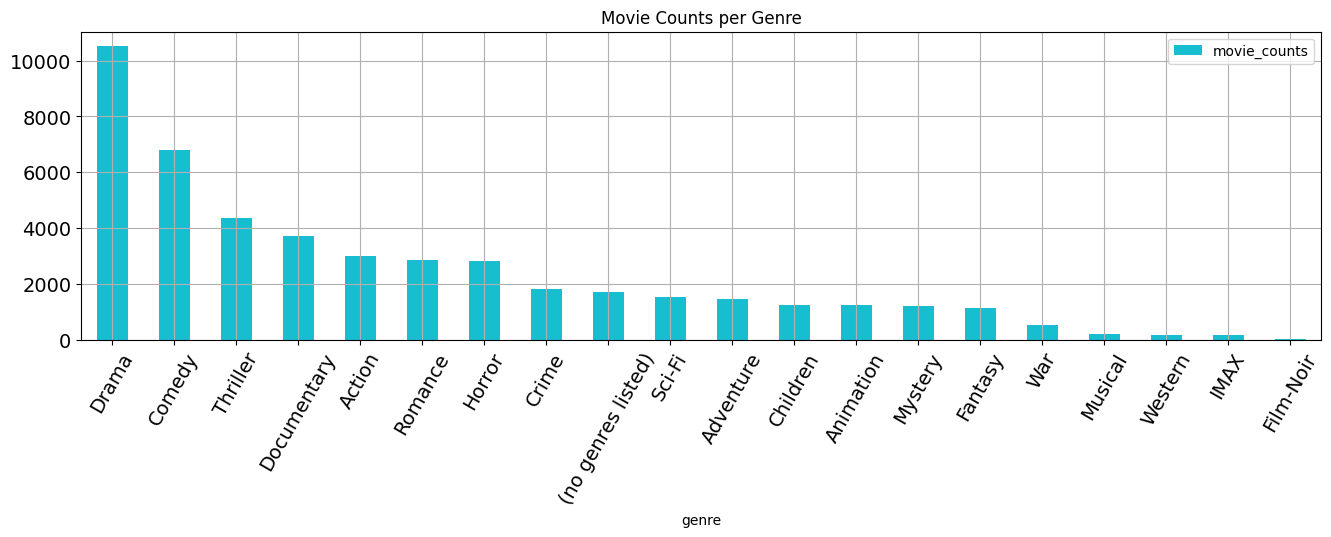

In [31]:
# Fetch unique list of genres available in the data  - total available genres
unique_genre = pd.DataFrame(movies_after_2005['genres'].str.split('|').to_list()).stack().unique()

# number of movies per gneres
from collections import Counter

# Now we count the number of movies per genre
genres_counts = Counter(pd.DataFrame(movies_after_2005['genres'].str.split('|').to_list()).stack().to_list())

# dump it back to a dataframe, sort by counts
df = pd.DataFrame(genres_counts.items(), columns=['genre','movie_counts']).sort_values('movie_counts', ascending=False)

# bar plot
bar_genres = df.plot.bar(x='genre' , rot = 60, figsize = (16,4), grid = True,
                         colormap = 'tab10_r',
                         title='Movie Counts per Genre',
                         fontsize = 14,  )

### High-MI actors in top genres

Recall from previous contents, we can apply MI analysis to see which actors have high MI with our top genres.

In [32]:
%%time

# We start by building a table of movie,actor,and genre from wikiData

hotmovieQuery = """
SELECT distinct ?movieLabel ?actorLabel ?genreLabel
WHERE {
  ?movie wdt:P31 wd:Q11424;        # Instance of a film
         wdt:P136 ?genre;          # Genre - replace wd:Q130232. with the Wikidata ID for drama or comedy
         wdt:P161 ?actor;          # Actor in the film
         wdt:P2142 ?boxOffice;     # Movie - box office -> ?boxOffice (a number)
         wdt:P577 ?releaseDate.     # Film's release date
  FILTER(YEAR(?releaseDate) > 2005) # Release date after 2005
  FILTER(?boxOffice > 10000000)     # Box office larger than 10M, so we can assume it's more likely we've heard about the titles

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
# Order by descending box office
#ORDER BY DESC(?boxOffice)
# We limit the number of returned results to 10000
limit 10000
"""

hotmovie_df = WikiDataQueryResults(hotmovieQuery).load_as_dataframe()
hotmovie_df

CPU times: user 422 ms, sys: 62.8 ms, total: 485 ms
Wall time: 20 s


,movieLabel,actorLabel,genreLabel
0,The Intouchables,Audrey Fleurot,film based on literature
1,The Intouchables,Émilie Caen,comedy film
2,The Intouchables,Benjamin Baroche,biographical film
3,The Intouchables,Benjamin Baroche,drama film
4,The Intouchables,Nicky Marbot,film based on literature
...,...,...,...
9995,Les Misérables,James Greene,romance film
9996,Les Misérables,Michael Jibson,musical film
9997,Les Misérables,Michael Jibson,drama film
9998,Les Misérables,Natalya Wallace,musical film


In [33]:
hotmovie_df["actorLabel"].value_counts()

Kristen Stewart       27
Woody Harrelson       27
Anna Kendrick         26
Robert Pattinson      26
Cameron Bright        23
                      ..
Yuki Saito             1
Marina Rocco           1
Kurosh Tahami          1
Roberto Della Casa     1
Alexandre Goyette      1
Name: actorLabel, Length: 2643, dtype: int64

In [34]:
hotmovie_df["movieLabel"].value_counts()

# We have about 200 movies and some good actor counts here, so the MI should be a reasonable measure

The Twilight Saga: Breaking Dawn – Part 1    378
The Twilight Saga: New Moon                  315
Child 44                                     290
The Twilight Saga: Eclipse                   259
The Hunger Games                             216
                                            ... 
Championext                                    4
Elena                                          3
Gorko! 2                                       2
Padre no hay más que uno                       1
Rage                                           1
Name: movieLabel, Length: 224, dtype: int64

In [35]:
MI_df = hotmovie_df.copy()

# Create a binary encoding for Drama and Comedy for each actor
MI_df['is_drama'] = MI_df['genreLabel'].apply(lambda x: 1 if x == 'drama film' else 0)
MI_df['is_comedy'] = MI_df['genreLabel'].apply(lambda x: 1 if x == 'comedy film' else 0)

# Create a binary column for each actor per movie
actor_movie_matrix = pd.pivot_table(MI_df, index='movieLabel', columns='actorLabel', aggfunc='size', fill_value=0)

# Aggregate these values at the movie level
genre_matrix = MI_df.groupby('movieLabel')['is_drama', 'is_comedy'].max()

# Merge the actor and genre matrices
actor_movie_matrix = actor_movie_matrix.merge(genre_matrix, left_index=True, right_index=True)

actor_movie_matrix

,Aamir Khan,Aaron Abrams,Aaron Ashmore,Aaron Himelstein,Aaron Lazar,Aaron Monaghan,Aaron Taylor-Johnson,Abbie Cornish,Abby Quinn,Abigail Breslin,...,Élodie Fontan,Émilie Caen,Émilie Dequenne,Éric Godon,Óscar Jaenada,Örvendi Cintia,Şafak Pekdemir,Željko Ivanek,is_drama,is_comedy
movieLabel,,,,,,,,,,,,,,,,,,,,,
3 Idiots,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"4 Months, 3 Weeks and 2 Days",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
A Better Tomorrow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A Hologram for the King,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
Aladdin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Yolki 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Zodiac,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [55]:
# And you all know this from Lab05
from sklearn.metrics import mutual_info_score

# Initialize a dictionary to store MI values
mi_scores = {}

# Iterate over actor columns to calculate MI with 'is_drama' and 'is_comedy'
for actor in actor_movie_matrix.columns:
    if actor != 'is_drama' and actor != 'is_comedy':
        drama_mi = mutual_info_score(actor_movie_matrix[actor], actor_movie_matrix['is_drama'])
        comedy_mi = mutual_info_score(actor_movie_matrix[actor], actor_movie_matrix['is_comedy'])
        mi_scores[actor] = {'Drama_MI_Score': drama_mi, 'Comedy_MI_Score': comedy_mi}

# Convert MI scores to a DataFrame
mi_df = pd.DataFrame.from_dict(mi_scores, orient='index')
mi_df

,Drama_MI_Score,Comedy_MI_Score
Aamir Khan,0.003437,0.001182
Aaron Abrams,0.002795,0.001182
Aaron Ashmore,0.002795,0.001182
Aaron Himelstein,0.003437,0.001182
Aaron Lazar,0.002795,0.001182
...,...,...
Éric Godon,0.002795,0.006553
Óscar Jaenada,0.006212,0.002371
Örvendi Cintia,0.002795,0.001182
Şafak Pekdemir,0.002795,0.001182


In [56]:
# Sort actors by MI score in descending order, show their relation to Drama
mi_df.sort_values(by='Drama_MI_Score', ascending=False)[["Drama_MI_Score"]].head(10)

,Drama_MI_Score
Woody Harrelson,0.015867
Brendan Gleeson,0.014153
Sigourney Weaver,0.013115
Liam Neeson,0.013115
Zoe Saldaña,0.013115
Adam Driver,0.011814
Robert Pattinson,0.011286
Anna Kendrick,0.011286
Ben Affleck,0.011286
Kristen Stewart,0.011286


In [57]:
# Sort actors by MI score in descending order, show their relation to Comedy
mi_df.sort_values(by='Comedy_MI_Score', ascending=False)[["Comedy_MI_Score"]].head(10)

,Comedy_MI_Score
Brendan Gleeson,0.021536
Carmen Machi,0.019863
Pat Shortt,0.019863
Penélope Cruz,0.016617
Zoe Saldaña,0.015463
Colin Farrell,0.014315
Daniel Craig,0.014315
Michael Shannon,0.014315
Stanley Tucci,0.014315
Lola Dueñas,0.013173


### Similar Movies

#### Similar according to tags

One way to measure similarity between two movies, is simply count the number of overlapping tags.

In [39]:
# Recall that from movie Lens we have tags
tags

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455
...,...,...,...,...
1093355,162521,66934,Neil Patrick Harris,1427311611
1093356,162521,103341,cornetto trilogy,1427311259
1093357,162534,189169,comedy,1527518175
1093358,162534,189169,disabled,1527518181


In [40]:
movies_after_2005.shape

# We have 26262 movies here
# The similarity matrix between two movies has the size 26262 x 26262
# This is too large for demonstration here, let's focus on more interesting one

(26262, 6)

In [41]:
# Let's say we want movies that have enough number of ratings for us to analysis
movies_after_2005_5000ratings = movies_after_2005[ (movies_after_2005['Count of Ratings']>5000) ]
movies_after_2005_5000ratings

# 215 is acceptable

,movieId,title,genres,year,rating,Count of Ratings
10677,44191,V for Vendetta (2006),Action|Sci-Fi|Thriller|IMAX,2006,3.91,25990
10679,44195,Thank You for Smoking (2006),Comedy|Drama,2006,3.82,10402
10681,44199,Inside Man (2006),Crime|Drama|Thriller,2006,3.89,8551
10700,44555,"Lives of Others, The (Das leben der Anderen) (...",Drama|Romance|Thriller,2006,4.20,9177
10718,44665,Lucky Number Slevin (2006),Crime|Drama|Mystery,2006,3.85,8994
...,...,...,...,...,...,...
39918,164179,Arrival (2016),Sci-Fi,2016,4.03,10087
40872,166528,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,2016,3.78,6850
41599,168250,Get Out (2017),Horror,2017,3.96,5010
41600,168252,Logan (2017),Action|Sci-Fi,2017,3.89,6739


In [42]:
# sync tags with movies_after_2005_1000ratings
tags_after_2005_5000ratings = tags[tags['movieId'].isin(movies_after_2005_5000ratings['movieId'])]
tags_after_2005_5000ratings

,userId,movieId,tag,timestamp
5,4,44665,unreliable narrators,1573943619
6,4,115569,tense,1573943077
7,4,115713,artificial intelligence,1573942979
8,4,115713,philosophical,1573943033
9,4,115713,tense,1573943042
...,...,...,...,...
1093346,162495,58998,Nudity (Full Frontal - Notable),1211702362
1093347,162501,112556,crazy wife,1421990253
1093348,162501,112556,crime,1421990253
1093349,162501,112556,the wife did it,1421990253


In [43]:
%%time

# One way to measure similarity between two movies, is simply count the number of overlapping tags

# Group by 'movieId' and aggregate the tags into a list
tags_grouped = tags_after_2005_5000ratings.groupby('movieId')['tag'].apply(list).reset_index()

# Initialize an empty DataFrame for similarity scores
similarity_matrix = pd.DataFrame(index=tags_grouped['movieId'], columns=tags_grouped['movieId'])

# Fill the matrix with similarity scores
for i in tags_grouped['movieId']:
    for j in tags_grouped['movieId']:
        if i != j:
            # Intersection of tags
            similarity_matrix.at[i, j] = len(set(tags_grouped[tags_grouped['movieId'] == i]['tag'].values[0]) &
                                             set(tags_grouped[tags_grouped['movieId'] == j]['tag'].values[0]))

similarity_matrix

CPU times: user 48 s, sys: 973 ms, total: 49 s
Wall time: 49 s


movieId,44191,44195,44199,44555,44665,45186,45447,45499,45517,45672,...,134853,139385,142488,148626,152081,164179,166528,168250,168252,176371
movieId,,,,,,,,,,,,,,,,,,,,,
44191,NaN,15,4,17,6,8,5,8,5,2,...,2,6,2,6,3,5,8,3,4,13
44195,15,NaN,4,4,1,3,7,4,6,2,...,4,4,3,12,2,2,1,8,0,4
44199,4,4,NaN,3,4,4,0,6,2,2,...,2,1,3,2,6,4,1,4,1,1
44555,17,4,3,NaN,5,2,3,0,3,1,...,4,1,0,4,1,7,2,3,2,5
44665,6,1,4,5,NaN,2,1,1,0,1,...,0,3,1,1,1,3,0,6,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164179,5,2,4,7,3,1,3,1,0,6,...,9,7,3,4,2,NaN,8,11,1,11
166528,8,1,1,2,0,4,2,7,2,0,...,8,2,1,2,7,8,NaN,4,4,5
168250,3,8,4,3,6,2,3,1,3,3,...,8,8,4,5,5,11,4,NaN,1,7


In [44]:
N=50

# Convert the matrix into a stack of pairs of movies
similarity_pairs = similarity_matrix.stack()

# Sort the pairs by similarity score
sorted_pairs = similarity_pairs.sort_values(ascending=False)

# Get the top N pairs
top_similar_movies = sorted_pairs.head(N)

# Map back to titles
movie_titles = dict(zip(movies_after_2005_5000ratings['movieId'], movies_after_2005_5000ratings['title']))
top_similar_movies.index = [(movie_titles[i], movie_titles[j]) for i, j in top_similar_movies.index]
top_similar_movies

(Dark Knight Rises, The (2012), Dark Knight, The (2008))                                                      44
(Dark Knight, The (2008), Dark Knight Rises, The (2012))                                                      44
(Hobbit: The Desolation of Smaug, The (2013), Hobbit: An Unexpected Journey, The (2012))                      41
(Hobbit: An Unexpected Journey, The (2012), Hobbit: The Desolation of Smaug, The (2013))                      41
(Avengers: Age of Ultron (2015), Avengers, The (2012))                                                        40
(Avengers, The (2012), Avengers: Age of Ultron (2015))                                                        40
(Interstellar (2014), Inception (2010))                                                                       39
(Harry Potter and the Half-Blood Prince (2009), Harry Potter and the Order of the Phoenix (2007))             39
(Harry Potter and the Order of the Phoenix (2007), Harry Potter and the Half-Blood Prince (2009)

The majority of these movies are part of the same series, such as:

- "Iron Man 3" (2013) and "Iron Man" (2008)
- "Iron Man" (2008) and "Iron Man 2" (2010)

Others are directed by the same filmmaker, like Christopher Nolan:

- "Interstellar" (2014) and "Inception" (2010)
- "The Dark Knight Rises" (2012) and "Inception" (2010)

Additionally, some pairs share similar technical features, like the use of IMAX 3D technology:

- "Avatar" (2009) and "Inception" (2010)

#### Similarity Based on Shared User Preferences

An alternative method to determine movie similarity involves analyzing the overlap of users who have expressed a liking for both films.

This approach computes the similarity by determining the set intersection cardinality, which refers to the number of common elements, between item columns in user-item matrices, utilizing tools like NumPy for efficient computation.

In [45]:
# Next, we grab the ratings
# We do not need timestamp
ratings_mat = ratings.drop(columns=['timestamp']).copy()

# We only care about movieIds in movies_after_2005_1000ratings
ratings_mat = ratings_mat[ ratings_mat['movieId'].isin(movies_after_2005_5000ratings["movieId"]) ]

# And we think rating >= 4 means the user really like the movie
ratings_mat['user_like'] = (ratings_mat['rating'] >= 4).astype(int)

ratings_mat

,userId,movieId,rating,user_like
586,3,44191,4.0,1
587,3,45186,3.5,0
588,3,45447,3.5,0
589,3,45499,4.0,1
591,3,45517,4.0,1
...,...,...,...,...
24999909,162540,68954,5.0,1
24999912,162540,69844,4.5,1
25000089,162541,45517,4.5,1
25000090,162541,50872,4.5,1


In [46]:
# We now create the user rating matrix, where rows are users and cols are movies
ratings_mat = ratings_mat.pivot(index='userId', columns='movieId', values='user_like')
ratings_mat.fillna(0, inplace=True)
ratings_mat

movieId,44191,44195,44199,44555,44665,45186,45447,45499,45517,45672,...,134853,139385,142488,148626,152081,164179,166528,168250,168252,176371
userId,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162534,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
162536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
162538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
%%time

N=50

# Rows: Users, Columns: Movies, Cell value: 1 if liked, 0 otherwise
# Convert to np for faster computation
ratings_array = ratings_mat.values

# Compute the dot product of the matrix with its transpose
# This gives a matrix where each (i, j) element is the count of users who liked both movie i and j
similarity_matrix = np.matmul(ratings_array.T, ratings_array)

# Number of movies
num_movies = similarity_matrix.shape[0]

# Extract movie pairs and their overlap counts
movie_pairs = []
for i in range(num_movies):
    for j in range(i + 1, num_movies):
        movie_pairs.append(((ratings_mat.columns[i], ratings_mat.columns[j]), similarity_matrix[i, j]))

# Sort movie pairs by overlap count in descending order
top_movie_pairs = sorted(movie_pairs, key=lambda x: x[1], reverse=True)[:N]

# Create a dictionary for movie ID to title mapping
movie_titles = pd.Series(movies_after_2005_5000ratings.title.values, index=movies_after_2005_5000ratings.movieId).to_dict()

# Replace movie IDs with titles in the top 20 pairs
top_movie_pairs_with_titles = [((movie_titles[pair[0][0]], movie_titles[pair[0][1]]), pair[1]) for pair in top_movie_pairs]

top_movie_pairs_with_titles

CPU times: user 467 ms, sys: 79.5 ms, total: 547 ms
Wall time: 892 ms


[(('Dark Knight, The (2008)', 'Inception (2010)'), 18789.0),
 (('Inception (2010)', 'Interstellar (2014)'), 12370.0),
 (('Departed, The (2006)', 'Dark Knight, The (2008)'), 12327.0),
 (('Dark Knight, The (2008)', 'WALL·E (2008)'), 12069.0),
 (('Dark Knight, The (2008)', 'Dark Knight Rises, The (2012)'), 11817.0),
 (('Dark Knight, The (2008)', 'Iron Man (2008)'), 11651.0),
 (('Prestige, The (2006)', 'Dark Knight, The (2008)'), 11536.0),
 (('WALL·E (2008)', 'Inception (2010)'), 11129.0),
 (('Prestige, The (2006)', 'Inception (2010)'), 11078.0),
 (('Dark Knight, The (2008)', 'Inglourious Basterds (2009)'), 11069.0),
 (('Inglourious Basterds (2009)', 'Inception (2010)'), 10724.0),
 (('Departed, The (2006)', 'Inception (2010)'), 10586.0),
 (('Dark Knight, The (2008)', 'Interstellar (2014)'), 10459.0),
 (('Inception (2010)', 'Dark Knight Rises, The (2012)'), 10437.0),
 (('WALL·E (2008)', 'Up (2009)'), 10383.0),
 (('V for Vendetta (2006)', 'Dark Knight, The (2008)'), 10270.0),
 (('Dark Knight

We see different pairs now, and hey, "WALL·E (2008)" is making quite the appearance:

- ('The Dark Knight (2008)', 'WALL·E (2008)')
- ('WALL·E (2008)', 'Inception (2010)')

Why is this charming robot hanging out with Nolan's big hits? A good guess is that it's just super popular. A high-rating charmer, "WALL·E" becomes a go-to pairing with pretty much any other hit movie. And it's the same story with "Up (2009)" – because who can resist those cuddly, feel-good vibes?

Plus, we're spotting some pairs that might differ in genre and plot but strike the same chord, mood-wise:
- ('Inception (2010)', 'The Imitation Game (2014)') – both are total mind-benders.
- ('Pan's Labyrinth (Laberinto del fauno, El) (2006)', 'The Dark Knight (2008)') – they've both got that dark, edgy feel.

#### Cosine Similarity Based on Shared User Preferences

Using a dot product for rating-based similarities can introduce biases, specifically **popularity** and **temporal** bias.

**popularity** bias: users rate mostly what is popular

**temporal** bias: users only provide ratings in a short temporal range

We're always going to get the temporal bias, but normalizing for vector length (=popularity) should improve the results. To reduce these biases, methods that explicitly incorporate normalization, such as Jaccard and Cosine Similarity, can be effective.

In this discussion, we will focus on Cosine Similarity, as it has been previously introduced.

While Jaccard Similarity falls outside the scope of this Lab, you're encouraged to experiment with it by modifying the lab code. Observe the variations in results using this method. For further information, refer to the following link: Jaccard Similarity on scikit-learn.

In [78]:
from sklearn.metrics.pairwise import cosine_similarity

N = 50

# Rows: Users, Columns: Movies, Cell value: 1 if liked, 0 otherwise
# Convert to np array for faster computation
ratings_array = ratings_mat.values

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(ratings_array.T)

# Number of movies
num_movies = similarity_matrix.shape[0]

# Extract movie pairs and their similarity scores
movie_pairs = []
for i in range(num_movies):
    for j in range(i + 1, num_movies):
        movie_pairs.append(((ratings_mat.columns[i], ratings_mat.columns[j]), similarity_matrix[i, j]))

# Sort movie pairs by similarity score in descending order
top_movie_pairs = sorted(movie_pairs, key=lambda x: x[1], reverse=True)[:N]

# Create a dictionary for movie ID to title mapping
movie_titles = pd.Series(movies_after_2005_5000ratings.title.values, index=movies_after_2005_5000ratings.movieId).to_dict()

# Replace movie IDs with titles in the top N pairs
top_movie_pairs_with_titles = [((movie_titles[pair[0][0]], movie_titles[pair[0][1]]), pair[1]) for pair in top_movie_pairs]

top_movie_pairs_with_titles


[(('Harry Potter and the Deathly Hallows: Part 1 (2010)',
   'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
  0.7372551410118866),
 (('Harry Potter and the Half-Blood Prince (2009)',
   'Harry Potter and the Deathly Hallows: Part 1 (2010)'),
  0.7358257408011523),
 (('Harry Potter and the Order of the Phoenix (2007)',
   'Harry Potter and the Half-Blood Prince (2009)'),
  0.6847767746526652),
 (('Harry Potter and the Half-Blood Prince (2009)',
   'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
  0.673121750382305),
 (('Hobbit: An Unexpected Journey, The (2012)',
   'Hobbit: The Desolation of Smaug, The (2013)'),
  0.6473379421184209),
 (('Harry Potter and the Order of the Phoenix (2007)',
   'Harry Potter and the Deathly Hallows: Part 1 (2010)'),
  0.6244028835537182),
 (('Avengers: Infinity War - Part I (2018)', 'Thor: Ragnarok (2017)'),
  0.6228104734123671),
 (('Harry Potter and the Order of the Phoenix (2007)',
   'Harry Potter and the Deathly Hallows: Part 2 (2011

Previously, "WALL·E (2008)" really highlighted the issue of popularity bias, popping up a lot in top pairs just because it's so well-known.

However, with the application of cosine similarity, this bias is reduced, resulting in movies being more accurately matched based on their content and potential shared audience base.

## Key take-away points

- You've shown how you can use Knowledge Graphs (KGs) and query different relations to construct custom Pandas tables for analysis of entities
- You've examined actors and computed their similarity in terms of the genre distribution of the movies they've acted in that you've obtained from a KG
- You've examined computing similarity between entities based off of different KG properties (similarity of two movies based on tags, similarity in terms of the number of users who have liked both)
- You've used different similarity metrics and have noted that normalizing for vector length using cosine similarity corrects for vector length (e.g., popularity) effects